In [ ]:
!wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

--2021-05-28 00:34:55--  https://lazyprogrammer.me/course_files/airline_passengers.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2036 (2.0K) [text/csv]
Saving to: ‘airline_passengers.csv’

airline_passengers. 100%[===================>]   1.99K  --.-KB/s    in 0s      

2021-05-28 00:34:55 (36.5 MB/s) - ‘airline_passengers.csv’ saved [2036/2036]



In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('airline_passengers.csv', index_col='Month', parse_dates=True)

In [ ]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [ ]:
df.isna().sum()

Passengers    0
dtype: int64

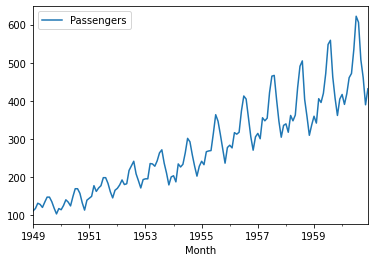

In [ ]:
df.plot();

In [ ]:
alpha = 0.2

In [ ]:
df['EWMA'] = df['Passengers'].ewm(alpha=alpha, adjust=False).mean()

In [ ]:
type(df['Passengers'].ewm(alpha=alpha, adjust=False))

pandas.core.window.ewm.ExponentialMovingWindow

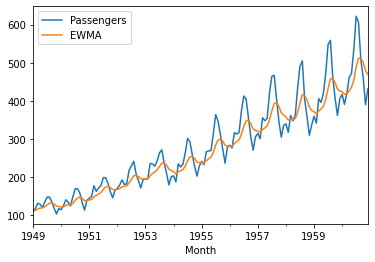

In [ ]:
df.plot();

In [ ]:
manual_ewma = []
for x in df['Passengers'].to_numpy():
  if len(manual_ewma) > 0:
    xhat = alpha * x + (1 - alpha) * manual_ewma[-1]
  else:
    xhat = x
  manual_ewma.append(xhat)
df['Manual'] = manual_ewma

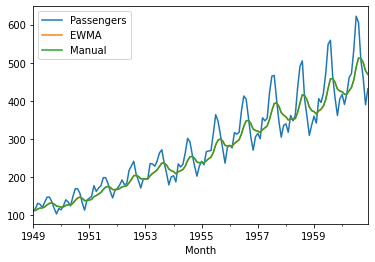

In [ ]:
df.plot();

In [ ]:
df.head()

,Passengers,EWMA,Manual
Month,,,
1949-01-01,112,112.0000,112.0000
1949-02-01,118,113.2000,113.2000
1949-03-01,132,116.9600,116.9600
1949-04-01,129,119.3680,119.3680
1949-05-01,121,119.6944,119.6944


In [ ]:
df.drop('Manual', axis=1, inplace=True)

In [ ]:
!pip install -U statsmodels

     |████████████████████████████████| 9.5MB 8.3MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [ ]:
ses = SimpleExpSmoothing(df['Passengers'])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


In [ ]:
# link to offset aliases docs
# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [ ]:
df.index.freq = 'MS'

In [ ]:
ses = SimpleExpSmoothing(
    df['Passengers'],
    initialization_method='legacy-heuristic')

In [ ]:
res = ses.fit(smoothing_level=alpha, optimized=False)

In [ ]:
res

In [ ]:
res.predict(start=df.index[0], end=df.index[-1])

Month
1949-01-01    112.000000
1949-02-01    112.000000
1949-03-01    113.200000
1949-04-01    116.960000
1949-05-01    119.368000
                 ...    
1960-08-01    488.767616
1960-09-01    512.214093
1960-10-01    511.371274
1960-11-01    501.297019
1960-12-01    479.037615
Freq: MS, Length: 144, dtype: float64

In [ ]:
df['SES'] = res.predict(start=df.index[0], end=df.index[-1])

In [ ]:
np.allclose(df['SES'], res.fittedvalues)

True

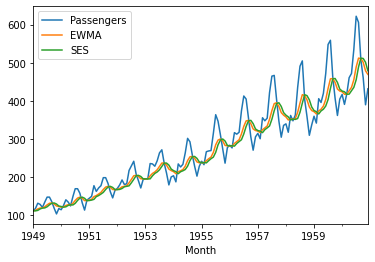

In [ ]:
df.plot();

In [ ]:
df.head()

,Passengers,EWMA,SES
Month,,,
1949-01-01,112,112.0000,112.000
1949-02-01,118,113.2000,112.000
1949-03-01,132,116.9600,113.200
1949-04-01,129,119.3680,116.960
1949-05-01,121,119.6944,119.368


In [ ]:
df['SES-1'] = df['SES'].shift(-1)

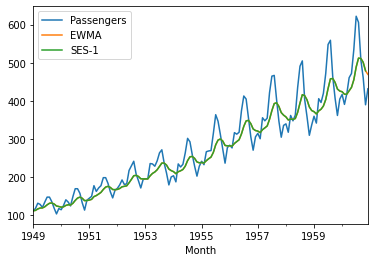

In [ ]:
### No!
df[['Passengers', 'EWMA', 'SES-1']].plot();

In [ ]:
N_test = 12
train = df.iloc[:-N_test]
test = df.iloc[-N_test:]

In [ ]:
ses = SimpleExpSmoothing(
    train['Passengers'],
    initialization_method='legacy-heuristic')
res = ses.fit()

In [ ]:
# boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

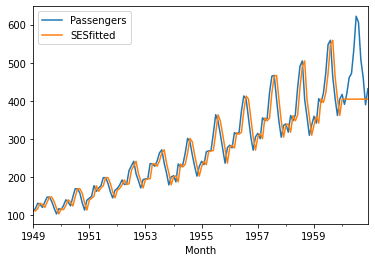

In [ ]:
df.loc[train_idx, 'SESfitted'] = res.fittedvalues
df.loc[test_idx, 'SESfitted'] = res.forecast(N_test)
df[['Passengers', 'SESfitted']].plot();

In [ ]:
res.params

{'damping_trend': nan,
 'initial_level': 112.0,
 'initial_seasons': array([], dtype=float64),
 'initial_trend': nan,
 'lamda': None,
 'remove_bias': False,
 'smoothing_level': 0.995,
 'smoothing_seasonal': nan,
 'smoothing_trend': nan,
 'use_boxcox': False}

In [ ]:
from statsmodels.tsa.holtwinters import Holt

In [ ]:
holt = Holt(
    df['Passengers'],
    initialization_method='legacy-heuristic')

In [ ]:
res_h = holt.fit()

In [ ]:
df['Holt'] = res_h.fittedvalues

In [ ]:
df[['Passengers', 'Holt']].plot();

In [ ]:
### No!
df['Holt-1'] = df['Holt'].shift(-1)
df[['Passengers', 'Holt-1']].plot();

In [ ]:
holt = Holt(train['Passengers'], initialization_method='legacy-heuristic')
res_h = holt.fit()
df.loc[train_idx, 'Holt'] = res_h.fittedvalues

In [ ]:
df.loc[test_idx, 'Holt'] = res_h.forecast(N_test)

In [ ]:
df[['Passengers', 'Holt']].plot();

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [ ]:
hw = ExponentialSmoothing(
    train['Passengers'],
    initialization_method='legacy-heuristic',
    trend='add', seasonal='add', seasonal_periods=12)
res_hw = hw.fit()

In [ ]:
df.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues

In [ ]:
df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test)

In [ ]:
df[['Passengers', 'HoltWinters']].plot();

In [ ]:
def rmse(y, t):
  return np.sqrt(np.mean((y - t)**2))

In [ ]:
def mae(y, t):
  return np.mean(np.abs(y - t))

In [ ]:
print("Train RMSE:", rmse(train['Passengers'], res_hw.fittedvalues))
print("Test RMSE:", rmse(test['Passengers'], res_hw.forecast(N_test)))

In [ ]:
print("Train MAE:", mae(train['Passengers'], res_hw.fittedvalues))
print("Test MAE:", mae(test['Passengers'], res_hw.forecast(N_test)))

In [ ]:
hw = ExponentialSmoothing(
    train['Passengers'],
    initialization_method='legacy-heuristic',
    trend='add', seasonal='mul', seasonal_periods=12)
res_hw = hw.fit()
df.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues
df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test)
df[['Passengers', 'HoltWinters']].plot();

In [ ]:
print("Train RMSE:", rmse(train['Passengers'], res_hw.fittedvalues))
print("Test RMSE:", rmse(test['Passengers'], res_hw.forecast(N_test)))

In [ ]:
print("Train MAE:", mae(train['Passengers'], res_hw.fittedvalues))
print("Test MAE:", mae(test['Passengers'], res_hw.forecast(N_test)))

In [ ]:
hw = ExponentialSmoothing(
    train['Passengers'],
    initialization_method='legacy-heuristic',
    trend='mul', seasonal='mul', seasonal_periods=12)
res_hw = hw.fit()
df.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues
df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test)
df[['Passengers', 'HoltWinters']].plot();

In [ ]:
print("Train RMSE:", rmse(train['Passengers'], res_hw.fittedvalues))
print("Test RMSE:", rmse(test['Passengers'], res_hw.forecast(N_test)))

In [ ]:
print("Train MAE:", mae(train['Passengers'], res_hw.fittedvalues))
print("Test MAE:", mae(test['Passengers'], res_hw.forecast(N_test)))